# Clustering Stocks Based On Value At Risk
Anggota Kelompok
1. Abdullah Nasih Jasir (5025211111)
2. Mohammad Ahnaf Fauzan (5025211170)
3. Al-Ferro Yudisthira Putra (5025211176)
# ---------------------------------------------------------------------------

### Import Libraries
Code di bawah guna melakukan import seluruh library yang dibutuhkan dalam final project ini

In [8]:
import os
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

# Visualitation Style
plt.style.use('ggplot')
%matplotlib inline

# ---------------------------------------------------------------------------
## **PREPROCESSING**
# ---------------------------------------------------------------------------

### Import Data
Code berikut berguna untuk mengimport data dari file csv yang tersimpan di folder history

In [2]:
path = 'saham'
all_rec = glob.iglob(path + '/*.csv', recursive=True)
count = 0

prices_df = pd.DataFrame()
for f in all_rec:
    count = count + 1
    df = pd.read_csv(f, index_col='date', usecols=['date', 'close'])
    colname = os.path.basename(f).replace('.csv', '')
    df.rename(columns={'close': colname}, inplace=True)
    prices_df = pd.concat([prices_df, df], axis=1, sort=False)

# Convert the 'Date' column to datetime format
prices_df.index = pd.to_datetime(prices_df.index)

# Define the date range
start_date = pd.to_datetime("2022-03-24")
end_date = pd.to_datetime("2023-03-24")

# Filter the data to include only the specified date range
prices_df = prices_df[(prices_df.index >= start_date) & (prices_df.index <= end_date)]

# Filter stocks with at least 100 data points within the date range
valid_stocks = prices_df.columns[prices_df.count() >= 200]

# Create a new DataFrame with the selected date range and valid stocks
prices_train = prices_df.loc[(prices_df.index >= start_date) & (prices_df.index <= end_date),valid_stocks]

#Interpolate to fill in the data that is null
prices_train = prices_train.interpolate(method='linear')
prices_train.head(10)

,ABBA,ABDA,ABMM,ACES,ACST,ADCP,ADES,ADHI,ADMF,ADMG,...,WSBP,WSKT,WTON,YELO,YPAS,YULE,ZBRA,ZINC,ZONE,ZYRX
date,,,,,,,,,,,,,,,,,,,,,
2022-03-24,300.0,6400.0,1670.0,995.0,197.0,94.0,3630.0,740.0,8400.0,181.0,...,95.0,570.0,222.0,121.0,452.0,2010.0,640.0,92.0,575.0,590.0
2022-03-25,296.0,6400.0,1625.0,1005.0,194.0,93.0,3630.0,735.0,8375.0,181.0,...,95.0,550.0,216.0,116.0,565.0,2010.0,615.0,91.0,595.0,600.0
2022-03-28,294.0,6400.0,1675.0,1015.0,192.0,93.0,3660.0,740.0,8375.0,184.0,...,95.0,555.0,216.0,114.0,705.0,2010.0,635.0,90.0,610.0,595.0
2022-03-29,294.0,6400.0,1680.0,1025.0,191.0,92.0,3680.0,740.0,8450.0,183.0,...,95.0,560.0,216.0,117.0,880.0,2010.0,600.0,90.0,600.0,565.0
2022-03-30,280.0,6400.0,1765.0,1025.0,191.0,92.0,3680.0,750.0,8550.0,181.0,...,95.0,555.0,218.0,116.0,1020.0,2020.0,630.0,90.0,630.0,600.0
2022-03-31,286.0,6400.0,1765.0,1025.0,193.0,90.0,3680.0,740.0,8575.0,184.0,...,95.0,550.0,218.0,114.0,950.0,2010.0,630.0,89.0,635.0,605.0
2022-04-01,284.0,6400.0,1780.0,1075.0,190.0,90.0,3680.0,725.0,8525.0,184.0,...,95.0,555.0,214.0,112.0,925.0,2020.0,625.0,90.0,630.0,600.0
2022-04-04,276.0,6400.0,1850.0,1110.0,190.0,90.0,3700.0,725.0,8650.0,184.0,...,95.0,550.0,216.0,113.0,980.0,2020.0,625.0,91.0,655.0,600.0
2022-04-05,284.0,6400.0,1975.0,1075.0,191.0,90.0,3690.0,730.0,8700.0,185.0,...,95.0,550.0,218.0,121.0,920.0,2020.0,625.0,92.0,680.0,580.0


# ---------------------------------------------------------------------------
## **FINDING VALUE AT RISK VALUE**
# ---------------------------------------------------------------------------
Untuk mendapatkan Nilai dari VaR, kita memerlukan beberapa pencaharian terlebih dahulu, yaitu
1. Expected Values
2. Mean of Expected Values
3. Standard Deviation

### Expected Values
Berikut merupakan algoritma pencarian expected values

In [3]:
# Expected Value = Value(t) - Value(t-1) / Value(t-1)
expected_df = (prices_train.diff() / prices_train.shift(1)).shift(-1)
expected_df.columns = [f'{col}' for col in expected_df.columns]
expected_df.dropna(how='all', inplace=True)
expected_df.head()

,ABBA,ABDA,ABMM,ACES,ACST,ADCP,ADES,ADHI,ADMF,ADMG,...,WSBP,WSKT,WTON,YELO,YPAS,YULE,ZBRA,ZINC,ZONE,ZYRX
date,,,,,,,,,,,,,,,,,,,,,
2022-03-24,-0.013333,0.0,-0.026946,0.010050,-0.015228,-0.010638,0.000000,-0.006757,-0.002976,0.000000,...,0.0,-0.035088,-0.027027,-0.041322,0.250000,0.000000,-0.039062,-0.010870,0.034783,0.016949
2022-03-25,-0.006757,0.0,0.030769,0.009950,-0.010309,0.000000,0.008264,0.006803,0.000000,0.016575,...,0.0,0.009091,0.000000,-0.017241,0.247788,0.000000,0.032520,-0.010989,0.025210,-0.008333
2022-03-28,0.000000,0.0,0.002985,0.009852,-0.005208,-0.010753,0.005464,0.000000,0.008955,-0.005435,...,0.0,0.009009,0.000000,0.026316,0.248227,0.000000,-0.055118,0.000000,-0.016393,-0.050420
2022-03-29,-0.047619,0.0,0.050595,0.000000,0.000000,0.000000,0.000000,0.013514,0.011834,-0.010929,...,0.0,-0.008929,0.009259,-0.008547,0.159091,0.004975,0.050000,0.000000,0.050000,0.061947
2022-03-30,0.021429,0.0,0.000000,0.000000,0.010471,-0.021739,0.000000,-0.013333,0.002924,0.016575,...,0.0,-0.009009,0.000000,-0.017241,-0.068627,-0.004950,0.000000,-0.011111,0.007937,0.008333


### Mean Expected Value
berikut merupakan pencarian dari mean expected values

In [4]:
# Calculate the mean (expected value) for each column in expected_df
expected_means = expected_df.mean()
expected_means.head()

ABBA   -0.003953
ABDA    0.000186
ABMM    0.002529
ACES   -0.002672
ACST   -0.001495
dtype: float64

### Standard Deviation
berikut merupakan pencarian dari standard deviation

In [5]:
# Calculate the standard deviation of daily returns for each stock
std_deviation = expected_df.std()
std_deviation.head()

ABBA    0.037665
ABDA    0.016857
ABMM    0.036793
ACES    0.027626
ACST    0.020972
dtype: float64

### Value at Risk
Dengan memanfaatkan hasil dari pencarian di atas, kita mampu menemukan nilai value-at-risk sebagaimana ditunjukkan dibawah

In [6]:
# Calculate Value at Risk
value_at_risk = std_deviation.copy()
value_at_risk = -(expected_means + std_deviation*norm.ppf(0.01))
value_at_risk.head(10)

ABBA    0.091575
ABDA    0.039030
ABMM    0.083064
ACES    0.066941
ACST    0.050284
ADCP    0.056662
ADES    0.064534
ADHI    0.055274
ADMF    0.021519
ADMG    0.033812
dtype: float64

# ---------------------------------------------------------------------------
# **CLUSTERING**
# ---------------------------------------------------------------------------
Setelah mendapatkan nilai VaR, kita akan melakukan clustering. Terdapat beberapa metode clustering yang digunakan, yaitu,
1. K-Means Algorithm
2. Agglomerative Algorithm
3. Gaussian Mixture Model (GMM) Algorithm
# ---------------------------------------------------------------------------

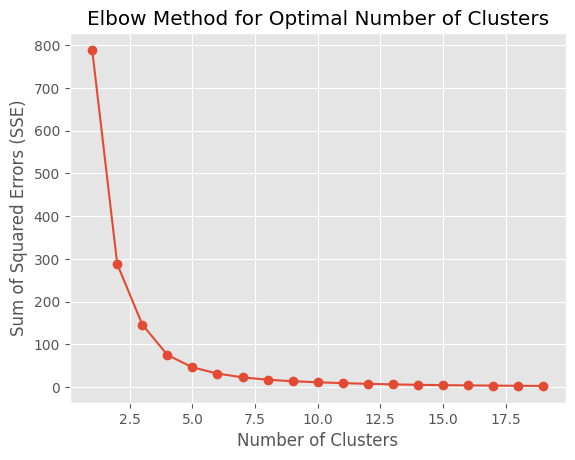

In [9]:
# Standardize the data
scaler = StandardScaler()
var_data_standardized = scaler.fit_transform(np.array(value_at_risk).reshape(-1, 1))

# Define a range of cluster numbers to try
clusters = range(1, 20)

# Initialize an empty list to store SSE values
sse = []

# Run K-Means for each cluster number and calculate SSE
for k in clusters:
    elbow = KMeans(n_clusters=k, random_state=42, n_init=13)
    elbow.fit(var_data_standardized)
    sse.append(elbow.inertia_)

# Plot the SSE values for each cluster number
plt.plot(clusters, sse, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

### **K-Means Algorithm**
Code berikut berguna untuk melakukan clustering menggunakan metode K-Means

In [10]:
# Standardize the data
scaler_kmeans = StandardScaler()
var_data_standardized_kmeans = scaler_kmeans.fit_transform(np.array(value_at_risk).reshape(-1, 1))

K = 5

# Perform K-means clustering
kmeans = KMeans(n_clusters=K, random_state=42)
clusters_kmeans = kmeans.fit_predict(var_data_standardized_kmeans)
clusters_kmeans = clusters_kmeans + 1

# Display the resulting clusters
result_df_kmeans = pd.DataFrame({'VaR': value_at_risk, 'Cluster': clusters_kmeans})
print(result_df_kmeans)

           VaR  Cluster
ABBA  0.091575        1
ABDA  0.039030        2
ABMM  0.083064        1
ACES  0.066941        3
ACST  0.050284        2
...        ...      ...
YULE  0.034381        2
ZBRA  0.032869        2
ZINC  0.034119        2
ZONE  0.067885        3
ZYRX  0.048668        2

[789 rows x 2 columns]


C:\Users\Abdullah NJ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Pin Point Graph of Every Stocks Based On K-Means Algorithm
Code berikut berguna untuk menunjukkan gambaran peta persebaran stock berdasarkan Expected Values dan VaR nya

C:\Users\Abdullah NJ\AppData\Local\Temp\ipykernel_17228\3846397792.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10', num_clusters)


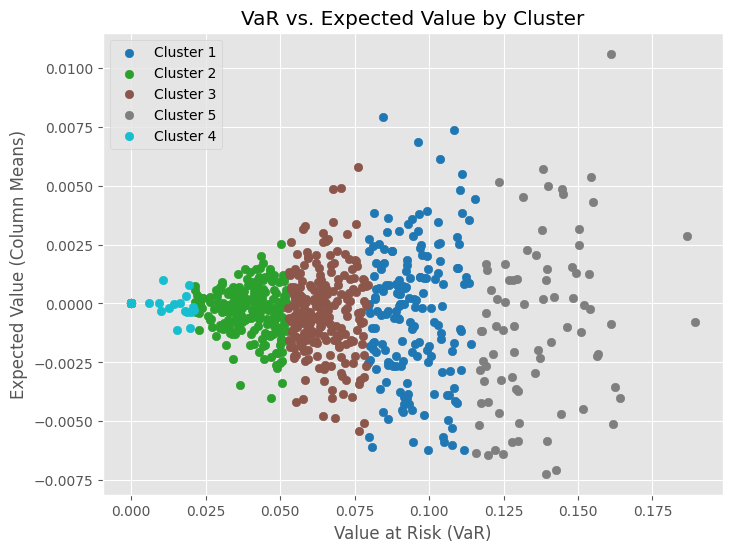

In [11]:
# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
num_clusters = result_df_kmeans['Cluster'].nunique()
color_palette = plt.cm.get_cmap('tab10', num_clusters) 

for i, cluster in enumerate(result_df_kmeans['Cluster'].unique()):
    cluster_data_kmeans = result_df_kmeans[result_df_kmeans['Cluster'] == cluster]
    plt.scatter(
        cluster_data_kmeans['VaR'],
        expected_means[cluster_data_kmeans.index],
        color=color_palette(i),
        label=f'Cluster {cluster}' 
    )

plt.title('VaR vs. Expected Value by Cluster')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Random 25 Stock Each Cluster Based On K-Means Algorithm
Untuk melihat detail persebaran lebih jelas, maka kita akan memilih 25 stock sebagai contoh

In [12]:
result_df_kmeans['Stocks'] = result_df_kmeans.index

# Function to pick 25 stocks randomly based on the cluster
def select_random_stocks_per_cluster(df):
    return df.groupby('Cluster').apply(lambda x: x.sample(n=25) if len(x) >= 25 else x).reset_index(drop=True)

# Create new DataFrame containing 25 random stocks per cluster or all of the stocks if there are less than 10 stocks available
newstockslist_kmeans = select_random_stocks_per_cluster(result_df_kmeans)
print(newstockslist_kmeans)

          VaR  Cluster Stocks
0    0.107124        1   JMAS
1    0.090054        1   BMAS
2    0.090299        1   IATA
3    0.079905        1   CARS
4    0.086404        1   KOBX
..        ...      ...    ...
120  0.144131        5   HRUM
121  0.161089        5   MIDI
122  0.139835        5   OKAS
123  0.131807        5   LAND
124  0.122225        5   ARTO

[125 rows x 3 columns]


### Pin Point K-Means Clusters of The Selected Stocks
Code di bawah melakukan penunjukan data dari 25 saham per cluster yang telah terpilih

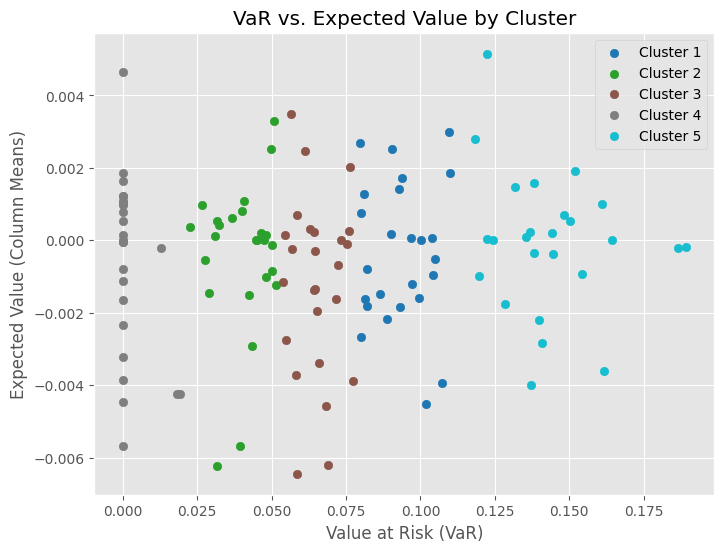

In [13]:
newclusters_kmeans = newstockslist_kmeans['Cluster'].unique()
num_clusters = len(newclusters_kmeans)

# Use the color palletes in order based on Matplotlib
color_palette = plt.cm.tab10(np.linspace(0, 1, num_clusters))

# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(newclusters_kmeans):
    cluster_data_kmeans = newstockslist_kmeans[newstockslist_kmeans['Cluster'] == cluster]
    plt.scatter(
        cluster_data_kmeans['VaR'],
        expected_means[cluster_data_kmeans.index],
        color=color_palette[i],  
        label=f'Cluster {cluster}'
    )

plt.title('VaR vs. Expected Value by Cluster')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Test Clustering Based On Selected Stocks on K-Means Algorithm

In [14]:
stock_name = "BBCA"
cluster_series = result_df_kmeans.loc[stock_name, 'Cluster'] if stock_name in result_df_kmeans.index else None

if cluster_series is not None:
    cluster = cluster_series
    print(f"The stock {stock_name} is in Cluster {cluster}\n")
    
    # Find stocks that are in the same cluster as the selected one
    same_cluster_stocks_kmeans = result_df_kmeans[result_df_kmeans['Cluster'] == cluster]

    # Display stocks that are in the same cluster as the selected one
    print(f"Other stocks in Cluster {cluster}:")
    print(same_cluster_stocks_kmeans.head(5))
else:
    print(f"The stock {stock_name} was not found in any cluster")

The stock BBCA is in Cluster 2

Other stocks in Cluster 2:
           VaR  Cluster Stocks
ABDA  0.039030        2   ABDA
ACST  0.050284        2   ACST
ADMF  0.021519        2   ADMF
ADMG  0.033812        2   ADMG
AMAG  0.036565        2   AMAG


# ---------------------------------------------------------------------------

### **Agglomerative Algorithm**
Code di bawah berguna untuk melakukan clustering berdasarkan Algoritma Agglomerative 

In [15]:
# Standardize the data
scaler_aglo = StandardScaler()
var_data_standardized_aglo = scaler_aglo.fit_transform(np.array(value_at_risk).reshape(-1, 1))

K = 5

# Perform Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=K)
clusters_aglo = agg_cluster.fit_predict(var_data_standardized_aglo)
clusters_aglo = clusters_aglo + 1

# Display the resulting clusters
result_df_aglo = pd.DataFrame({'VaR': value_at_risk, 'Cluster': clusters_aglo})
print(result_df_aglo)

           VaR  Cluster
ABBA  0.091575        4
ABDA  0.039030        2
ABMM  0.083064        4
ACES  0.066941        5
ACST  0.050284        2
...        ...      ...
YULE  0.034381        2
ZBRA  0.032869        2
ZINC  0.034119        2
ZONE  0.067885        5
ZYRX  0.048668        2

[789 rows x 2 columns]


### Bar Plot Every Stocks Based On Agglomerative Algorithm
Code di bawah berguna untuk memvisualisasikan data persebaran berdasarkan Expected Values dan VaR dari algoritma Agglomerative

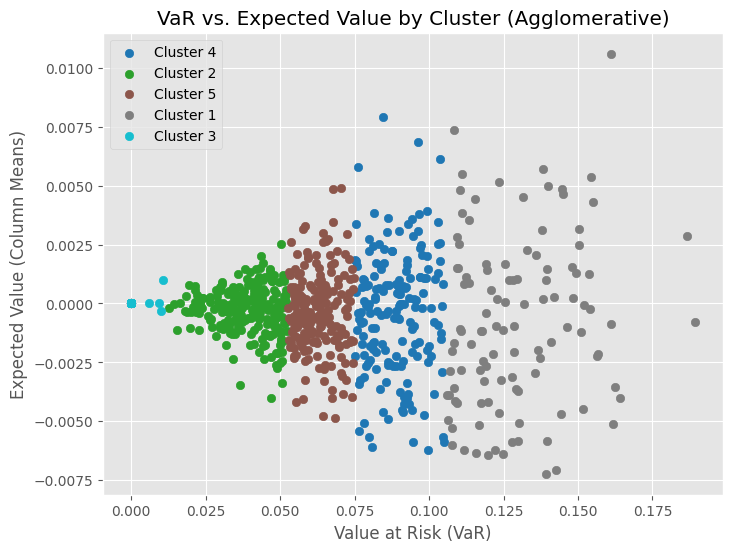

In [16]:
# Pick cluster count that is unique
num_clusters_aglo = result_df_aglo['Cluster'].nunique()

# Use the color palletes in order based on Matplotlib
color_palette_aglo = plt.cm.tab10(np.linspace(0, 1, num_clusters_aglo))

# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(result_df_aglo['Cluster'].unique()):
    cluster_data_aglo = result_df_aglo[result_df_aglo['Cluster'] == cluster]
    plt.scatter(
        cluster_data_aglo['VaR'],
        expected_means[cluster_data_aglo.index],
        color=color_palette_aglo[i], 
        label=f'Cluster {cluster}'
    )

plt.title('VaR vs. Expected Value by Cluster (Agglomerative)')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Random 25 Stock Each Cluster Based On Agglomerative Algorithm
Untuk melihat data lebih jelas, maka diambil 25 stock per cluster untuk di visualisasikan

In [17]:
result_df_aglo['Stocks'] = result_df_aglo.index

# Function to pick 25 stocks randomly based on the cluster
def select_random_stocks_per_cluster(df):
    return df.groupby('Cluster').apply(lambda x: x.sample(n=25) if len(x) >= 25 else x).reset_index(drop=True)

# Create new DataFrame containing 25 random stocks per cluster or all of the stocks if there are less than 10 stocks available
new_stocks_list_aglo = select_random_stocks_per_cluster(result_df_aglo)
print(new_stocks_list_aglo)

          VaR  Cluster Stocks
0    0.122654        1   PGLI
1    0.109458        1   BBYB
2    0.150325        1   YPAS
3    0.151106        1   SMDR
4    0.139835        1   OKAS
..        ...      ...    ...
120  0.068242        5   BCIP
121  0.074351        5   SATU
122  0.062850        5   PPGL
123  0.067000        5   SCMA
124  0.061327        5   UNSP

[125 rows x 3 columns]


### Pin Point Agglomerative Clusters of The Selected Stocks
Code di bawah melakukan penunjukan data dari 25 saham per cluster yang telah terpilih

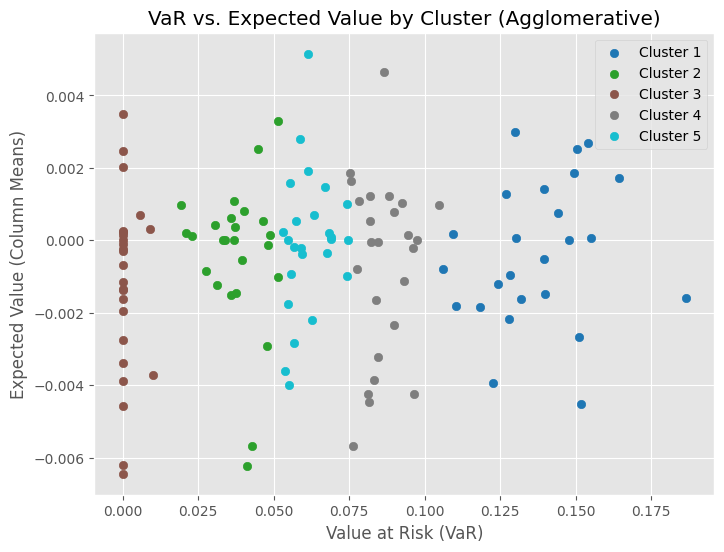

In [18]:
newclusters_aglo = new_stocks_list_aglo['Cluster'].unique()
num_clusters_aglo = len(newclusters_aglo)

# Use the color palletes in order based on Matplotlib
color_palette_aglo = plt.cm.tab10(np.linspace(0, 1, num_clusters_aglo))

# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(newclusters_aglo):
    cluster_data_aglo = new_stocks_list_aglo[new_stocks_list_aglo['Cluster'] == cluster]
    plt.scatter(
        cluster_data_aglo['VaR'],
        expected_means[cluster_data_aglo.index],
        color=color_palette_aglo[i],  
        label=f'Cluster {cluster}'
    )

plt.title('VaR vs. Expected Value by Cluster (Agglomerative)')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Test Clustering Based On Selected Stocks on Agglomerative Algorithm

In [19]:
stock_name = "BBCA"
cluster_series_aglo = result_df_aglo.loc[stock_name, 'Cluster'] if stock_name in result_df_aglo.index else None

if cluster_series_aglo is not None:
    cluster_aglo = cluster_series_aglo
    print(f"The stock {stock_name} is in Cluster {cluster_aglo}\n")
    
    # Find stocks that are in the same cluster as the selected one
    same_cluster_stocks_aglo = result_df_aglo[result_df_aglo['Cluster'] == cluster_aglo]

    # Display stocks that are in the same cluster as the selected one
    print(f"Other stocks in Cluster {cluster_aglo}:")
    print(same_cluster_stocks_aglo.head(5))
else:
    print(f"The stock {stock_name} was not found in any cluster")

The stock BBCA is in Cluster 2

Other stocks in Cluster 2:
           VaR  Cluster Stocks
ABDA  0.039030        2   ABDA
ACST  0.050284        2   ACST
ADMF  0.021519        2   ADMF
ADMG  0.033812        2   ADMG
AMAG  0.036565        2   AMAG


# ---------------------------------------------------------------------------

### **GMM Algorithm**
Code dibawah berguna untuk melakukan implementasi dari algoritma GMM dalam melakukan Clustering

In [20]:
# Standardize the data
scaler_gmm = StandardScaler()
var_data_standardized_gmm = scaler_gmm.fit_transform(np.array(value_at_risk).reshape(-1, 1))

K_gmm = 5

# Perform GMM Clustering
gmm_cluster = GaussianMixture(n_components=K_gmm, random_state=42)
clusters_gmm = gmm_cluster.fit_predict(var_data_standardized_gmm)
clusters_gmm = clusters_gmm + 1

# Display the resulting clusters
result_df_gmm = pd.DataFrame({'VaR': value_at_risk, 'Cluster': clusters_gmm})
print(result_df_gmm)


           VaR  Cluster
ABBA  0.091575        2
ABDA  0.039030        1
ABMM  0.083064        2
ACES  0.066941        3
ACST  0.050284        1
...        ...      ...
YULE  0.034381        1
ZBRA  0.032869        1
ZINC  0.034119        1
ZONE  0.067885        3
ZYRX  0.048668        1

[789 rows x 2 columns]


### Bar Plot Every Stocks Based On GMM Algorithm
Berikut merupakan Visualisasi seluruh stock berdasarkan Expected Values dan VaR dari Algoritma GMM

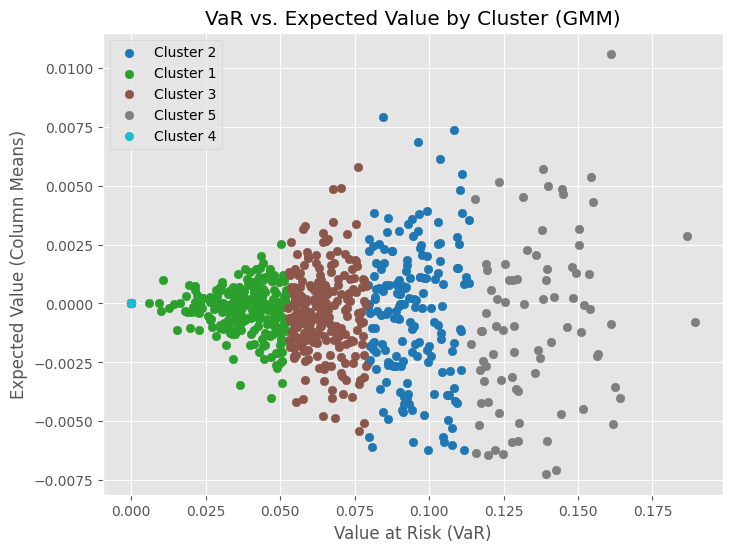

In [21]:
# Define colors for each cluster
num_clusters_gmm = len(result_df_gmm['Cluster'].unique())
color_palette_gmm = plt.cm.tab10(np.linspace(0, 1, num_clusters_gmm))

# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(result_df_gmm['Cluster'].unique()):
    cluster_data_gmm = result_df_gmm[result_df_gmm['Cluster'] == cluster]
    plt.scatter(
        cluster_data_gmm['VaR'],
        expected_means[cluster_data_gmm.index],
        color=color_palette_gmm[i], 
        label=f'Cluster {cluster}'
    )

plt.title('VaR vs. Expected Value by Cluster (GMM)')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Random 25 Stock Each Cluster Based On GMM Algorithm
Untuk melihat data lebih jelas, maka diambil 25 stock per cluster untuk di visualisasikan

In [22]:
result_df_gmm['Stocks'] = result_df_gmm.index

# Function to pick 25 stocks randomly based on the cluster 
def select_random_stocks_per_cluster(df):
    return df.groupby('Cluster').apply(lambda x: x.sample(n=25) if len(x) >= 25 else x).reset_index(drop=True)

# Create new DataFrame containing 25 random stocks per cluster or all of the stocks if there are less than 10 stocks available
newstockslist_gmm = select_random_stocks_per_cluster(result_df_gmm)
print(newstockslist_gmm)

          VaR  Cluster Stocks
0    0.030492        1   CASA
1    0.043918        1   ANJT
2    0.042979        1   JSKY
3    0.019307        1   SFAN
4    0.029891        1   NISP
..        ...      ...    ...
120  0.118180        5   PBRX
121  0.129781        5   TNCA
122  0.153950        5   HITS
123  0.124858        5   KIOS
124  0.138085        5   NZIA

[125 rows x 3 columns]


### Pin Point GMM Clusters of The Selected Stocks
Code di bawah melakukan penunjukan data dari 25 saham per cluster yang telah terpilih

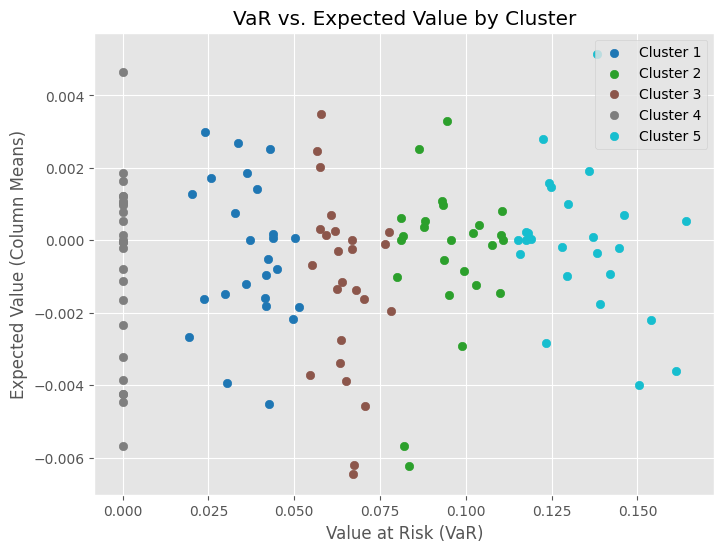

In [23]:
newclusters_gmm = newstockslist_gmm['Cluster'].unique()
num_clusters_gmm = len(newclusters_gmm)

# Use color palletes in order based on Matplotlib
color_palette_gmm = plt.cm.tab10(np.linspace(0, 1, num_clusters_gmm))

# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(newclusters_gmm):
    cluster_data_gmm = newstockslist_gmm[newstockslist_gmm['Cluster'] == cluster]
    plt.scatter(
        cluster_data_gmm['VaR'],
        expected_means[cluster_data_gmm.index],
        color=color_palette_gmm[i], 
        label=f'Cluster {cluster}'
    )

plt.title('VaR vs. Expected Value by Cluster')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Test Clustering Based On Selected Stocks on GMM Algorithm

In [24]:
stock_name = "BBCA"
cluster_series_gmm = result_df_gmm.loc[stock_name, 'Cluster'] if stock_name in result_df_gmm.index else None

if cluster_series_gmm is not None:
    cluster_gmm = cluster_series_gmm
    print(f"The stock {stock_name} is in Cluster {cluster_gmm}\n")
    
    # Find stocks that are in the same cluster as the selected one
    same_cluster_stocks_gmm = result_df_gmm[result_df_gmm['Cluster'] == cluster_gmm]

    # Display stocks that are in the same cluster as the selected one
    print(f"Other stocks in Cluster {cluster_gmm}:")
    print(same_cluster_stocks_gmm.head(5))
else:
    print(f"The stock {stock_name} was not found in any cluster")

The stock BBCA is in Cluster 1

Other stocks in Cluster 1:
           VaR  Cluster Stocks
ABDA  0.039030        1   ABDA
ACST  0.050284        1   ACST
ADMF  0.021519        1   ADMF
ADMG  0.033812        1   ADMG
AMAG  0.036565        1   AMAG


# ---------------------------------------------------------------------------
# COMPARISON
# ---------------------------------------------------------------------------

### Mean VaR of Clusters Analysis Based On Algorithm
Untuk mengetahui persamaan cluster dari setiap algoritma, maka perlu dilakukannya analisis berdasarkan mean VaR dari setiap clusternya

### K-Means Algorithm
Berikut merupakan visualisasi dari Mean VaR algoritma K-Means

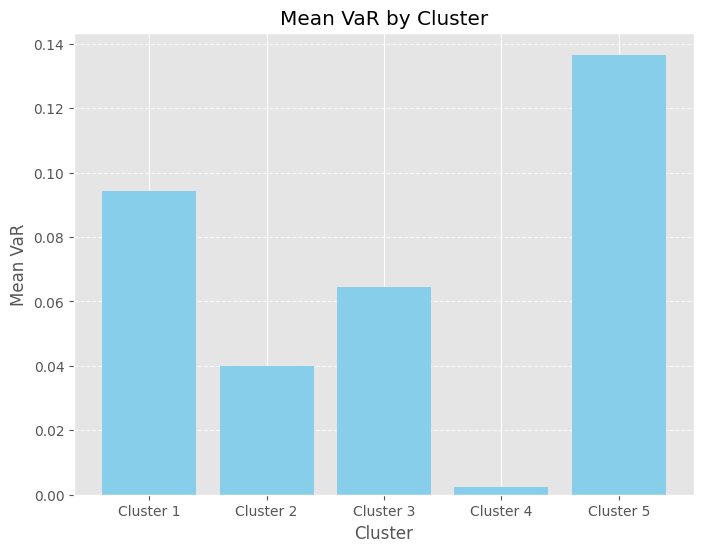

In [25]:
grouped_df_kmeans = result_df_kmeans.groupby('Cluster')['VaR'].mean().reset_index()
cluster_labels = [f'Cluster {label}' for label in grouped_df_kmeans['Cluster']]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(cluster_labels, grouped_df_kmeans['VaR'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('Mean VaR by Cluster')
plt.xticks(cluster_labels) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.show()


### Agglomerative Algorithm
Berikut merupakan visualisasi dari Mean VaR algoritma Aggloemerative

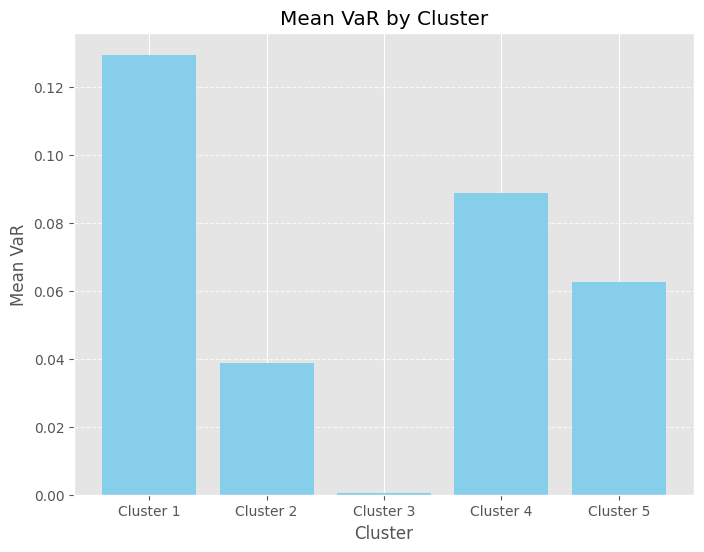

In [26]:
grouped_df_aglo = result_df_aglo.groupby('Cluster')['VaR'].mean().reset_index()
cluster_labels_aglo = [f'Cluster {label}' for label in grouped_df_aglo['Cluster']]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(cluster_labels_aglo, grouped_df_aglo['VaR'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('Mean VaR by Cluster')
plt.xticks(cluster_labels_aglo)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.show()

### GMM Algorithm
Berikut merupakan visualisasi dari Mean VaR algoritma GMM

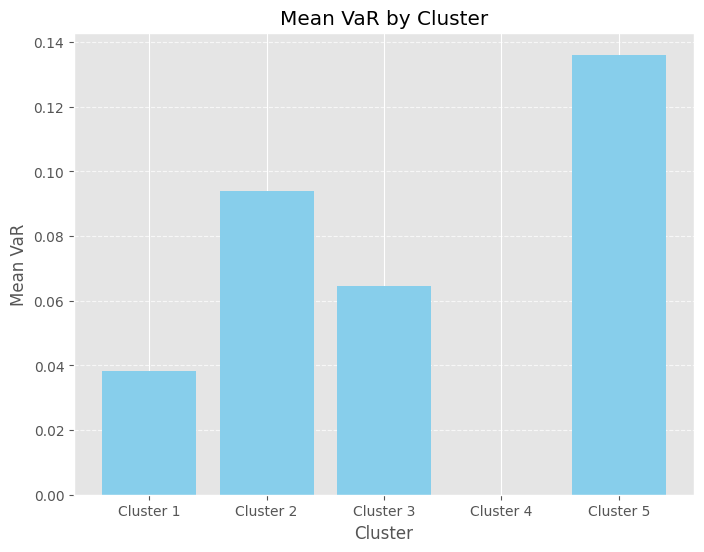

In [27]:
grouped_df_gmm = result_df_gmm.groupby('Cluster')['VaR'].mean().reset_index()
cluster_labels_gmm = [f'Cluster {label}' for label in grouped_df_gmm['Cluster']]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(cluster_labels_gmm, grouped_df_gmm['VaR'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('Mean VaR by Cluster')
plt.xticks(cluster_labels_gmm) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.show()

### Perbandingan 3 Algoritma
Berikut adalah grafik perbandingan Mean VaR pada setiap cluster

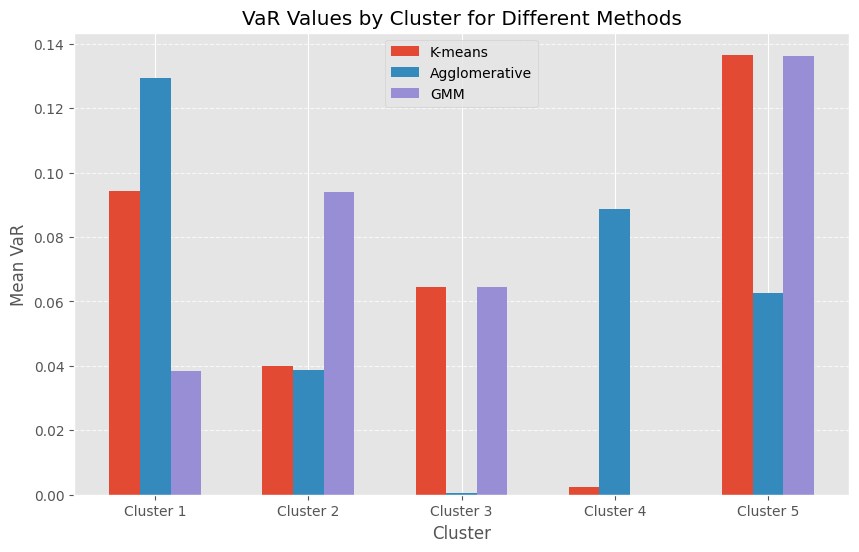

In [28]:
bar_width = 0.2

# Cluster position on x-axis
x_clusters = np.arange(len(grouped_df_kmeans))

plt.figure(figsize=(10, 6))

# Bar plot for K-means
plt.bar(x_clusters - bar_width, grouped_df_kmeans['VaR'], width=bar_width, label='K-means')

# Bar plot for Agglomerative clustering
plt.bar(x_clusters, grouped_df_aglo['VaR'], width=bar_width, label='Agglomerative')

# Bar plot ufor GMM
plt.bar(x_clusters + bar_width, grouped_df_gmm['VaR'], width=bar_width, label='GMM')

# Set labels and title
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('VaR Values by Cluster for Different Methods')
plt.xticks(x_clusters, [f'Cluster {label}' for label in grouped_df_gmm['Cluster']])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display Plot
plt.show()


#### Note
Pemberian label kepada kluster (dalam bentuk 1, 2, 3, 4, atau 5) dalam proses pengelompokan data menggunakan algoritma-algoritma tertentu tidak selalu mengikuti urutan dari risiko terendah ke tertinggi. Penamaan kluster dalam metode pengelompokan cenderung bersifat acak. Meskipun demikian, setiap kluster dari algoritma yang berbeda tetap memiliki karakteristik yang serupa, meskipun label yang diberikan mungkin berbeda-beda.

### Cluster Sorting Based On The Mean VaR
Guna menyamakan nama cluster sesuai dengan karakteristiknya, maka perlu dilakukannya pengurutan cluster berdasarkan nilai Mean VaR nya

In [29]:
def get_cluster_summary(df, algorithm_name):
    # Extract numeric columns
    numeric_columns = df.select_dtypes(include='number')
    
    # Calculate mean values for each cluster
    cluster_means = numeric_columns.groupby('Cluster').mean()['VaR']
    
    # Explicitly sort the mean values
    cluster_means_sorted = cluster_means.sort_values()
    
    # Create a DataFrame with mean values and cluster counts
    summary = pd.DataFrame({
        f'Mean VaR': cluster_means_sorted,
        f'Counts': df['Cluster'].value_counts().reindex(cluster_means_sorted.index)
    })
    
    return summary

# Get cluster summaries for each algorithm
kmeans_summary = get_cluster_summary(result_df_kmeans, 'K-Means')
aglo_summary = get_cluster_summary(result_df_aglo, 'Agglomerative')
gmm_summary = get_cluster_summary(result_df_gmm, 'GMM')

# Display the individual summaries
print("K-Means Cluster Summary:")
print(kmeans_summary)

print("\nAgglomerative Cluster Summary:")
print(aglo_summary)

print("\nGMM Cluster Summary:")
print(gmm_summary)

K-Means Cluster Summary:
         Mean VaR  Counts
Cluster                  
4        0.002511     100
2        0.040030     215
3        0.064610     221
1        0.094318     173
5        0.136619      80

Agglomerative Cluster Summary:
         Mean VaR  Counts
Cluster                  
3        0.000407      88
2        0.038862     227
5        0.062651     191
4        0.088751     174
1        0.129508     109

GMM Cluster Summary:
         Mean VaR  Counts
Cluster                  
4        0.000000      84
1        0.038344     231
3        0.064543     220
2        0.093993     172
5        0.136085      82


### Change of Cluster Order based On The Sorted Mean VaR
Dengan data yang di dapatkan, maka kita akan melakukan perubahan nama cluster untuk menyesuaikan ketiga algoritma

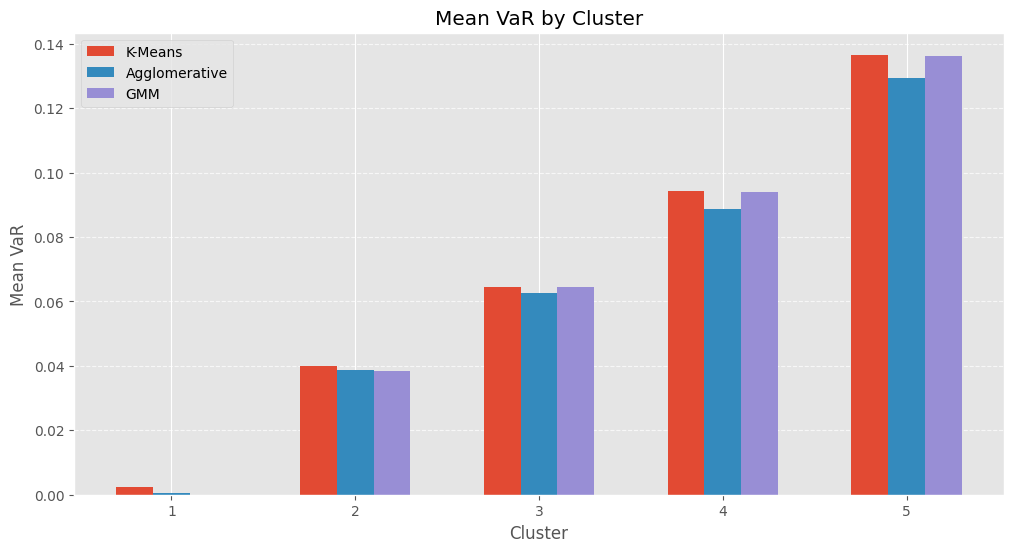

In [32]:
# Create copy of DataFrame without changing the original one
dfs = [result_df_kmeans, result_df_aglo, result_df_gmm]
new_dfs = [df.copy() for df in dfs]

# Determine the pattern of value subtitution
clusters = [kmeans_summary, aglo_summary, gmm_summary]

# Subtitute the value based on the pattern mentioned
for i, df in enumerate(new_dfs):
    df['Cluster'] = df['Cluster'].replace({clusters[i].index[j]: j+1 for j in range(5)})

# Save the result on the variable created earlier
newresult_df_kmeans, newresult_df_aglo, newresult_df_gmm = new_dfs

# Plot mean VaR for each cluster and algorithm after reassigning clusters
def get_cluster_summary(df, algorithm_name):
    numeric_columns = df.select_dtypes(include='number')
    cluster_means = numeric_columns.groupby('Cluster').mean()['VaR']
    cluster_means_sorted = cluster_means.sort_values()
    summary = pd.DataFrame({
        f'Mean VaR': cluster_means_sorted,
        f'Counts': df['Cluster'].value_counts().reindex(cluster_means_sorted.index)
    })
    return summary

# Get cluster summaries for each algorithm after reassigning clusters
new_kmeans_summary = get_cluster_summary(newresult_df_kmeans, 'K-Means')
new_aglo_summary = get_cluster_summary(newresult_df_aglo, 'Agglomerative')
new_gmm_summary = get_cluster_summary(newresult_df_gmm, 'GMM')

# Plot bar plot for mean VaR by cluster and algorithm after reassigning clusters
plt.figure(figsize=(12, 6))

bar_width = 0.2
x_kmeans = np.arange(len(new_kmeans_summary))
x_aglo = np.arange(len(new_aglo_summary)) + bar_width
x_gmm = np.arange(len(new_gmm_summary)) + 2 * bar_width

plt.bar(x_kmeans, new_kmeans_summary['Mean VaR'], width=bar_width, label='K-Means')
plt.bar(x_aglo, new_aglo_summary['Mean VaR'], width=bar_width, label='Agglomerative')
plt.bar(x_gmm, new_gmm_summary['Mean VaR'], width=bar_width, label='GMM')

plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('Mean VaR by Cluster')
plt.xticks(np.arange(len(new_gmm_summary)) + bar_width, new_gmm_summary.index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


### Comparison of The Number of Stocks in Every Cluster
Berikut merupakan gambaran dari jumlah stocks di tiap Cluster

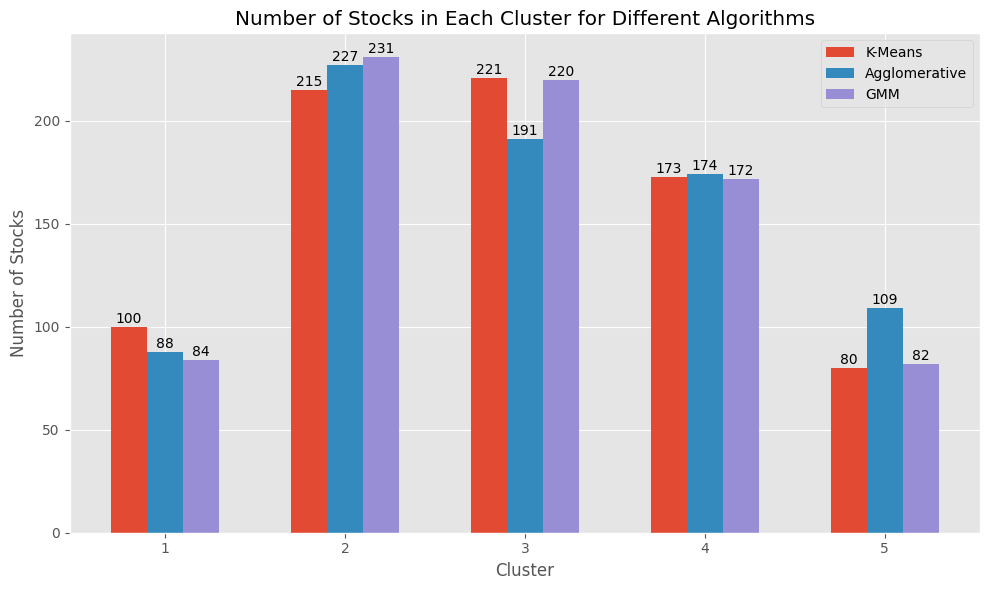

In [33]:
# Count the number of stocks in each cluster for each DataFrame
kmeans_cluster_counts = newresult_df_kmeans['Cluster'].value_counts().sort_index()
aglo_cluster_counts = newresult_df_aglo['Cluster'].value_counts().sort_index()
gmm_cluster_counts = newresult_df_gmm['Cluster'].value_counts().sort_index()

# Create a bar plot to compare the number of stocks in each cluster for each algorithm
plt.figure(figsize=(10, 6))

bar_width = 0.2
index = kmeans_cluster_counts.index  

plt.bar(index - bar_width, kmeans_cluster_counts, width=bar_width, label='K-Means')
plt.bar(index, aglo_cluster_counts, width=bar_width, label='Agglomerative')
plt.bar(index + bar_width, gmm_cluster_counts, width=bar_width, label='GMM')

# Display count values on top of each bar
for i, v in enumerate(kmeans_cluster_counts):
    plt.text(i + 1 - bar_width, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(aglo_cluster_counts):
    plt.text(i+1, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(gmm_cluster_counts):
    plt.text(i + 1 + bar_width, v + 0.5, str(v), ha='center', va='bottom')

plt.xlabel('Cluster')
plt.ylabel('Number of Stocks')
plt.title('Number of Stocks in Each Cluster for Different Algorithms')
plt.xticks(index)
plt.legend()
plt.tight_layout()
plt.show()


### Stock Cluster 1
Berikut merupakan data Stock yang berada pada cluster 1 di setiap algoritma

In [34]:
# Choose stocks with the cluster of 1 in each algorithm
stocks_kmeans_cluster1 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 1]['Stocks']
stocks_aglo_cluster1 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 1]['Stocks']
stocks_gmm_cluster1 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 1]['Stocks']

# Find stocks that are in the cluster 1 on every algorithm
stocks_in_clusters1 = set(stocks_kmeans_cluster1) & set(stocks_aglo_cluster1) & set(stocks_gmm_cluster1)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 1 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters1))

Stock berikut memiliki cluster 1 di ketiga algoritma:
'GOLL', 'UNIT', 'MAMIP', 'RONY', 'AKKU', 'VIVA', 'TRIL', 'NUSA', 'BAPI', 'MTFN', 'TARA', 'TOPS', 'OCAP', 'MTRA', 'MAGP', 'SUGI', 'POSA', 'HADE', 'HOME', 'PLAS', 'NIPS', 'PADI', 'COWL', 'TAMU', 'MAMI', 'CPRI', 'RIMO', 'KPAL', 'SKYB', 'MIRA', 'BUVA', 'HDTX', 'KIAS', 'DUCK', 'BTEL', 'IIKP', 'LAPD', 'MGNA', 'KPAS', 'DPUM', 'ARMY', 'RMBA', 'KBRI', 'KOTA', 'BEKS', 'SCPI', 'SMRU', 'CNTB', 'MYRXP', 'TDPM', 'DADA', 'FORZ', 'SIMA', 'HKMU', 'MDRN', 'JKSW', 'CTTH', 'EPAC', 'ELTY', 'TAXI', 'JGLE', 'CNKO', 'IBFN', 'DEFI', 'POOL', 'KRAH', 'NASA', 'SBAT', 'BTEK', 'MABA', 'TRIO', 'HOTL', 'GAMA', 'SRIL', 'TRAM', 'DEAL', 'ARTI', 'IKAI', 'LCGP', 'BLTA', 'ANDI', 'MKNT', 'ENVY', 'MYRX'


### Stock Cluster 2
Berikut merupakan data Stock yang berada pada cluster 2 di setiap algoritma

In [35]:
# Choose stocks with the cluster of 2 in each algorithm
stocks_kmeans_cluster2 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 2]['Stocks']
stocks_aglo_cluster2 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 2]['Stocks']
stocks_gmm_cluster2 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 2]['Stocks']

# Find stocks that are in the cluster 2 on every algorithm
stocks_in_clusters2 = set(stocks_kmeans_cluster2) & set(stocks_aglo_cluster2) & set(stocks_gmm_cluster2)

# Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 2 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters2))

Stock berikut memiliki cluster 2 di ketiga algoritma:
'IPCM', 'INDF', 'RBMS', 'ULTJ', 'WTON', 'SOHO', 'INDS', 'CLPI', 'KLBF', 'WIKA', 'PRIM', 'LPCK', 'MLPT', 'DNET', 'INAI', 'PZZA', 'EPMT', 'PTPP', 'BBRI', 'TAPG', 'NRCA', 'PPRO', 'INTA', 'BIPP', 'INCI', 'FASW', 'CBMF', 'ASRI', 'ASII', 'BPII', 'ASDM', 'UCID', 'CAMP', 'EDGE', 'SIMP', 'BSDE', 'MCOR', 'GWSA', 'ACST', 'CMNT', 'WOWS', 'MDIA', 'LIFE', 'BHAT', 'LMPI', 'NATO', 'EAST', 'CMNP', 'GMFI', 'JSMR', 'RSGK', 'JPFA', 'AMAG', 'TBIG', 'ADMG', 'DMAS', 'MTLA', 'IPCC', 'CITA', 'INKP', 'ARKA', 'ZYRX', 'CARE', 'GOOD', 'PMMP', 'SMBR', 'DVLA', 'PRAS', 'PYFA', 'DSFI', 'PTPW', 'TCID', 'TURI', 'BNGA', 'BMRI', 'TBLA', 'SMSM', 'NTBK', 'IGAR', 'TFCO', 'SOCI', 'IFII', 'TIFA', 'SPTO', 'PNGO', 'DPNS', 'KEJU', 'MAYA', 'NISP', 'IPOL', 'MAIN', 'PJAA', 'TOWR', 'ASGR', 'UNTR', 'MSIN', 'HEXA', 'TLKM', 'ISSP', 'TELE', 'PGAS', 'GIAA', 'JSPT', 'TRUE', 'BINA', 'SGRO', 'ADMF', 'KBLI', 'SIDO', 'ATIC', 'ITIC', 'CINT', 'BBTN', 'ZBRA', 'ZINC', 'PWON', 'MASB', 'BBMD', 'A

### Stock Cluster 3
Berikut merupakan data Stock yang berada pada cluster 3 di setiap algoritma

In [36]:
# Choose stocks with the cluster of 3 in each algorithm
stocks_kmeans_cluster3 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 3]['Stocks']
stocks_aglo_cluster3 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 3]['Stocks']
stocks_gmm_cluster3 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 3]['Stocks']

# Find stocks that are in the cluster 3 on every algorithm
stocks_in_clusters3 = set(stocks_kmeans_cluster3) & set(stocks_aglo_cluster3) & set(stocks_gmm_cluster3)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 3 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters3))

Stock berikut memiliki cluster 3 di ketiga algoritma:
'SOFA', 'AGII', 'DKFT', 'NOBU', 'TPMA', 'MBSS', 'WICO', 'CSIS', 'PTRO', 'AVIA', 'MCAS', 'WMUU', 'COCO', 'RODA', 'ARTA', 'TOTO', 'FISH', 'SWAT', 'GEMS', 'IPTV', 'NPGF', 'SKLT', 'AMFG', 'POLY', 'LFLO', 'SPMA', 'SAME', 'BKSW', 'SAFE', 'TGRA', 'BBKP', 'MAPI', 'MBTO', 'MTMH', 'KOIN', 'LPPS', 'CMRY', 'AMAR', 'KAEF', 'BULL', 'KICI', 'MKPI', 'CFIN', 'FREN', 'ADHI', 'TINS', 'RISE', 'FLMC', 'BGTG', 'MBAP', 'PRDA', 'CSAP', 'AMOR', 'SATU', 'GPRA', 'PLIN', 'BBSI', 'LRNA', 'HERO', 'PSGO', 'PSSI', 'SSIA', 'SRTG', 'BIKE', 'ESTI', 'JAST', 'BRPT', 'EXCL', 'IMJS', 'BEST', 'ACES', 'WOMF', 'ASJT', 'ADES', 'CPRO', 'SMRA', 'MMLP', 'DART', 'DIVA', 'ECII', 'BAYU', 'AMRT', 'BTPS', 'MAPB', 'DSSA', 'POLI', 'OILS', 'IKBI', 'UNSP', 'BKSL', 'RANC', 'AKRA', 'PSAB', 'BFIN', 'BCIP', 'CLEO', 'STTP', 'LPKR', 'GGRM', 'DNAR', 'MAPA', 'INCO', 'ITMG', 'MDKA', 'ADRO', 'WIFI', 'WGSH', 'LUCK', 'TEBE', 'LPLI', 'DUTI', 'GGRP', 'PAMG', 'BALI', 'JIHD', 'BUKK', 'TIRA', 'INDY', 'M

### Stock Cluster 4
Berikut merupakan data Stock yang berada pada cluster 4 di setiap algoritma

In [37]:
# Choose stocks with the cluster of 4 in each algorithm
stocks_kmeans_cluster4 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 4]['Stocks']
stocks_aglo_cluster4 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 4]['Stocks']
stocks_gmm_cluster4 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 4]['Stocks']

# Find stocks that are in the cluster 4 on every algorithm
stocks_in_clusters4 = set(stocks_kmeans_cluster4) & set(stocks_aglo_cluster4) & set(stocks_gmm_cluster4)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 4 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters4))

Stock berikut memiliki cluster 4 di ketiga algoritma:
'VINS', 'ESIP', 'MRAT', 'NETV', 'DOID', 'PEGE', 'BBSS', 'SMMT', 'TALF', 'PNBS', 'FITT', 'BCIC', 'TMPO', 'IDEA', 'NFCX', 'BRMS', 'ALMI', 'BBHI', 'LEAD', 'MREI', 'SAPX', 'WEHA', 'KOPI', 'AIMS', 'ENRG', 'AMAN', 'ETWA', 'UVCR', 'TRJA', 'MEDC', 'TRUK', 'CASH', 'HAIS', 'DWGL', 'ROCK', 'KBLV', 'ITMA', 'BESS', 'ASBI', 'RUIS', 'BUMI', 'AMIN', 'ESSA', 'IATA', 'AKPI', 'BLTZ', 'ABMM', 'BAJA', 'GLOB', 'RIGS', 'BRNA', 'CAKK', 'LABA', 'CNTX', 'KARW', 'KBLM', 'SEMA', 'SUPR', 'INDO', 'ADMR', 'WMPP', 'RICY', 'BMAS', 'SKBM', 'RELI', 'BANK', 'FPNI', 'ERTX', 'IPAC', 'BABP', 'PSDN', 'ALTO', 'UNIQ', 'PANR', 'BOLA', 'HELI', 'CENT', 'SOTS', 'CTBN', 'DIGI', 'INCF', 'WINS', 'RMKE', 'ASSA', 'APLI', 'KOBX', 'ABBA', 'OLIV', 'PKPK', 'CARS', 'LUCY', 'RAJA', 'ENZO', 'TOYS', 'GDST', 'MASA', 'BNBR', 'PBSA', 'IBST', 'DEWA', 'ATAP', 'SHIP', 'SQMI', 'RUNS', 'JAWA', 'LPGI', 'ASPI', 'DAYA', 'SIPD', 'SBMA', 'BKDP', 'PCAR', 'BBLD', 'INPP', 'PNBN', 'MPOW', 'AKSI', 'OPMS', 'P

### Stock Cluster 5
Berikut merupakan data Stock yang berada pada cluster 5 di setiap algoritma

In [38]:
# Choose stocks with the cluster of 5 in each algorithm
stocks_kmeans_cluster5 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 5]['Stocks']
stocks_aglo_cluster5 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 5]['Stocks']
stocks_gmm_cluster5 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 5]['Stocks']

# Find stocks that are in the cluster 5 on every algorithm
stocks_in_clusters5 = set(stocks_kmeans_cluster5) & set(stocks_aglo_cluster5) & set(stocks_gmm_cluster5)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 5 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters5))

Stock berikut memiliki cluster 5 di ketiga algoritma:
'PTDU', 'SDPC', 'HOMI', 'SILO', 'HOPE', 'ESTA', 'FIRE', 'BAPA', 'POLU', 'HRUM', 'ALKA', 'OASA', 'BPTR', 'TPIA', 'PTIS', 'SULI', 'SINI', 'JTPE', 'BMSR', 'FMII', 'EKAD', 'BSML', 'OKAS', 'SMDR', 'PGUN', 'HDIT', 'INDX', 'PURI', 'SGER', 'UFOE', 'DFAM', 'NZIA', 'KIOS', 'TNCA', 'MTWI', 'FORU', 'HDFA', 'KONI', 'POLL', 'SDMU', 'HITS', 'ASHA', 'OMRE', 'PICO', 'PGLI', 'INTD', 'UANG', 'WIRG', 'MIDI', 'BOSS', 'GPSO', 'ASMI', 'MTPS', 'KJEN', 'MGLV', 'PBRX', 'ARTO', 'INPS', 'WINR', 'WAPO', 'BELL', 'BEBS', 'TRIS', 'SICO', 'TFAS', 'BYAN', 'IPPE', 'PANI', 'BIMA', 'SLIS', 'LAND', 'MLIA', 'SKRN', 'MTSM', 'TAYS', 'TECH', 'AHAP', 'AYLS', 'YPAS', 'GZCO'


# ---------------------------------------------------------------------------
## Features
# ---------------------------------------------------------------------------

### Note
Value at Risk (VaR) adalah metode untuk menaksir seberapa besar potensi kerugian pada investasi dengan tingkat kepercayaan tertentu. Sebagai contoh, dengan VaR 0,56 pada tingkat kepercayaan 99%, terdapat probabilitas 99% bahwa kerugian investasi tidak akan melebihi 56% dalam periode tertentu.

Secara umum, semakin rendah nilai VaR, semakin stabil dan kurang fluktuatif harga sahamnya, menandakan risiko yang lebih rendah. Sebaliknya, semakin tinggi nilai VaR, semakin besar fluktuasi harga sahamnya, menunjukkan tingkat risiko yang lebih tinggi dalam perubahan harga saham setiap hari.

### Merging All The Clusters Into One Data Frame
Code dibawah berguna untuk melakukan penyatuan seluruh cluster kedalam satu dataframe

In [39]:
# Merge three DataFrame based on 'Stock' and 'Cluster' Columns
finalresult_df = pd.merge(newresult_df_kmeans, newresult_df_aglo, on=['VaR', 'Stocks', 'Cluster'])
finalresult_df = pd.merge(finalresult_df, newresult_df_gmm, on=['VaR', 'Stocks', 'Cluster'])

print(finalresult_df)

          VaR  Cluster Stocks
0    0.091575        4   ABBA
1    0.039030        2   ABDA
2    0.083064        4   ABMM
3    0.066941        3   ACES
4    0.050284        2   ACST
..        ...      ...    ...
709  0.034381        2   YULE
710  0.032869        2   ZBRA
711  0.034119        2   ZINC
712  0.067885        3   ZONE
713  0.048668        2   ZYRX

[714 rows x 3 columns]


### Feature 1
#### Testing a specific Stock to where it falls in cluster while also recommending some stocks that fall in the same cluster.

Saham PTDU berada pada Cluster 5
Cluster 5: Investasi dalam klaster ini memiliki risiko yang Sangat Tinggi.

5 saham dengan Resiko Terendah di Cluster 5:
          VaR Stocks  Cluster
642  0.115638   TECH        5
427  0.116793   MGLV        5
349  0.117195   JTPE        5
269  0.117516   GZCO        5
239  0.117530   FIRE        5



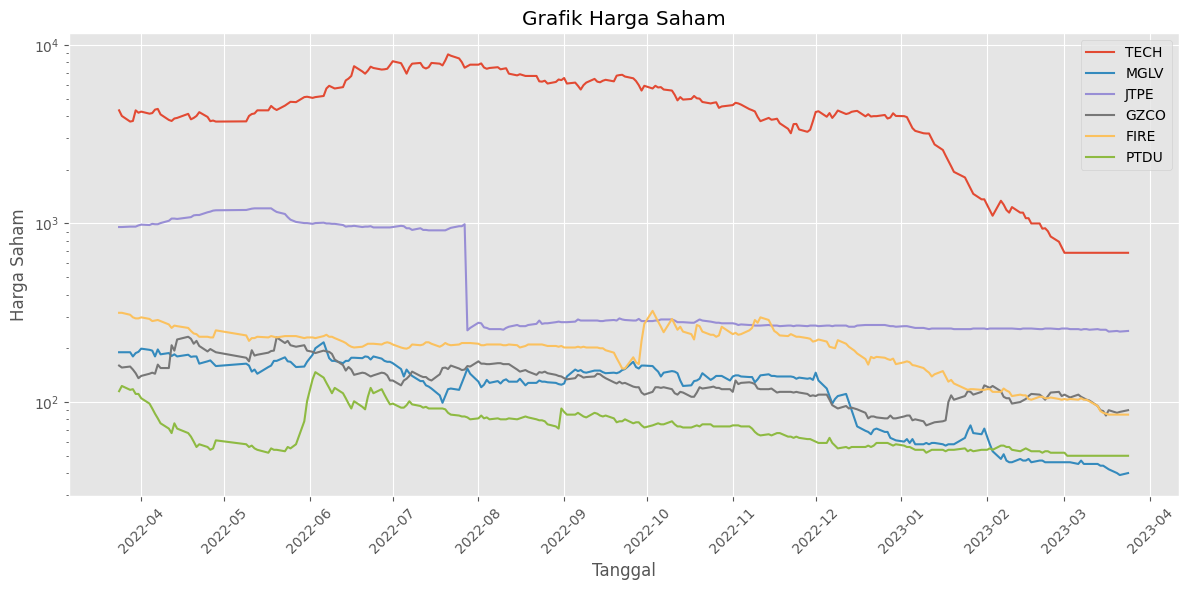

In [46]:
def print_cluster_info(cluster, cluster_data):
    risk_levels = {
        1: "Sangat Rendah",
        2: "Rendah",
        3: "Sedang",
        4: "Tinggi",
        5: "Sangat Tinggi"
    }

    print(f"Cluster {cluster}: Investasi dalam klaster ini memiliki risiko yang {risk_levels.get(cluster, 'tidak dikenal')}.\n")

    top_5_highest_var = cluster_data.head(5)
    
    print(f"5 saham dengan Resiko Terendah di Cluster {cluster}:")
    print(top_5_highest_var[['VaR', 'Stocks', 'Cluster']], end='\n\n')

stock_name = "PTDU"
cluster_final = finalresult_df[finalresult_df.Stocks == stock_name]['Cluster']

if not cluster_final.empty:
    clusters_found = cluster_final.unique()
    cluster_data_dict = {}

    for cluster in clusters_found:
        print(f"Saham {stock_name} berada pada Cluster {cluster}")
        same_cluster_final = finalresult_df[finalresult_df['Cluster'] == cluster]
        sorted_cluster = same_cluster_final.sort_values(by='VaR', ascending=True)
        cluster_data_dict[cluster] = sorted_cluster.head(5)

        print_cluster_info(cluster, cluster_data_dict[cluster])

    additional_stocksfix = [cluster_data['Stocks'].tolist() for cluster_data in cluster_data_dict.values()]
    stocks_to_plot = [item for sublist in additional_stocksfix for item in sublist] + [stock_name]

    selected_stocks = prices_df[stocks_to_plot]

    plt.figure(figsize=(12, 6))
    for stock in stocks_to_plot:
        plt.semilogy(selected_stocks.index, selected_stocks[stock], label=stock)

    plt.title('Grafik Harga Saham')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Saham')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print(f"Saham {stock_name} tidak ditemukan di cluster manapun")

### Feature 2
#### Giving some stocks recommendation depending on the cluster risk level.

In [50]:
# Memilih tingkat risiko
tingkat_resiko = "Sangat Rendah"

# Dictionary for the mapping of the risk level
tingkat_resiko_to_cluster = {
    "Sangat Rendah": 1,
    "Rendah": 2,
    "Sedang": 3,
    "Tinggi": 4,
    "Sangat Rendah": 5
}

# Check if the result is valid
if tingkat_resiko in tingkat_resiko_to_cluster:
    cluster = tingkat_resiko_to_cluster[tingkat_resiko]
    emiten_cluster = finalresult_df[finalresult_df['Cluster'] == cluster]['Stocks']
    
    if not emiten_cluster.empty:
        if len(emiten_cluster) < 10:
            print(f"Rekomendasi emiten untuk tingkat Risiko '{tingkat_resiko}':")
            for emiten in emiten_cluster:
                print(emiten)
        else:
            emiten_rekomendasi = random.sample(emiten_cluster.tolist(), k=10)
            print(f"Rekomendasi 10 emiten untuk tingkat Risiko '{tingkat_resiko}':")
            for emiten in emiten_rekomendasi:
                print(emiten)
    else:
        print(f"Tidak ada emiten untuk tingkat Risiko '{tingkat_resiko}'")
else:
    print("Tingkat risiko tidak valid")


Rekomendasi 10 emiten untuk tingkat Risiko 'Sangat Rendah':
SINI
WIRG
SDMU
INTD
MTPS
PANI
INPS
ASHA
PURI
OMRE


# ---------------------------------------------------------------------------
## EVALUATION
# ---------------------------------------------------------------------------


### Silhouette Score

Silhouette Score K-Means: 0.5752819056609645
Silhouette Score GMM: 0.5639782444057138
Silhouette Score Agglomerative Clustering: 0.5602406807429251


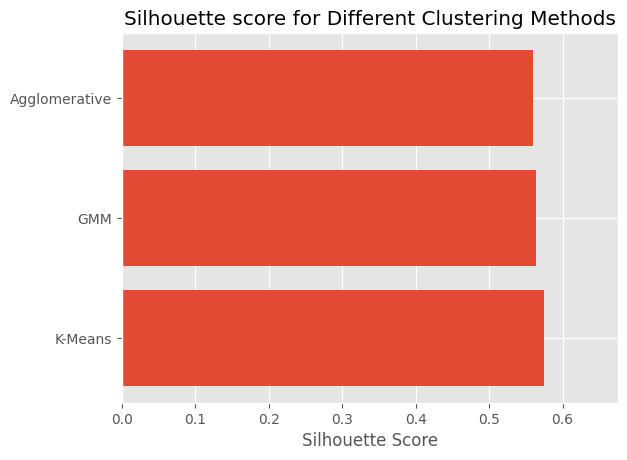

In [51]:
# Take the result of clustering from the all the algorithms
test1_clusters_kmeans = result_df_kmeans['Cluster']  # Clustering result of K-Means
test1_clusters_gmm = result_df_gmm['Cluster']   # Clustering result of GMM
test1_clusters_aglo = result_df_aglo['Cluster']   # Clustering result of Agglomerical

# Count the silhouette score of every clustering method
silhouette_kmeans = silhouette_score(var_data_standardized_kmeans, test1_clusters_kmeans)
silhouette_gmm = silhouette_score(var_data_standardized_gmm, test1_clusters_gmm)
silhouette_aglo = silhouette_score(var_data_standardized_aglo, test1_clusters_aglo)

# Display the result
print(f"Silhouette Score K-Means: {silhouette_kmeans}")
print(f"Silhouette Score GMM: {silhouette_gmm}")
print(f"Silhouette Score Agglomerative Clustering: {silhouette_aglo}")

methods = ['K-Means', 'GMM', 'Agglomerative']
scores = [silhouette_kmeans, silhouette_gmm, silhouette_aglo]

# Create a bar chart
plt.barh(methods, scores)
plt.xlabel('Silhouette Score')
plt.title('Silhouette score for Different Clustering Methods')
plt.xlim([0, max(scores) + 0.1])  # Adjust the x-axis limits if needed

# Display the plot
plt.show()

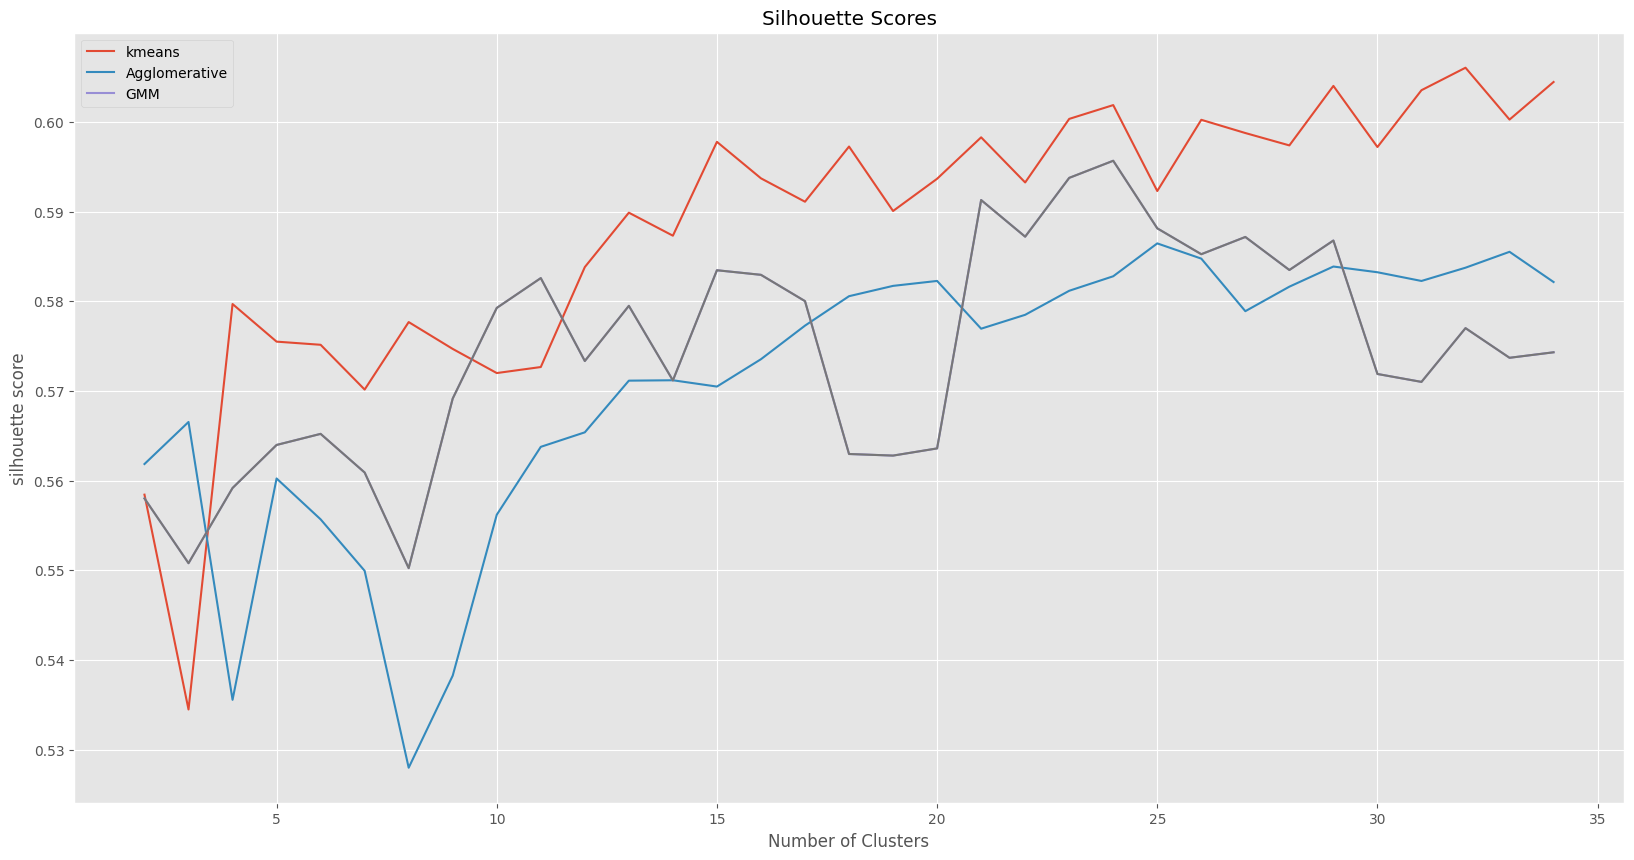

In [52]:
clusters=range(2,35,1)

# Compute the silhouette score for K means cluster within the range
scores = []
for k in clusters:
    km = KMeans(n_clusters=k,random_state=0, n_init=10)
    labels = km.fit_predict(var_data_standardized_kmeans)
    score = silhouette_score(var_data_standardized_kmeans,labels)
    scores.append(score)


plt.figure(figsize=(20,10))
plt.plot(clusters,scores)

# Compute the silhouette score for Agglomerative cluster within the range
scores = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k)
    labels = ag.fit_predict(var_data_standardized_aglo)
    score = silhouette_score(var_data_standardized_aglo,labels)
    scores.append(score)

plt.plot(clusters,scores)

# Compute the silhouette score for GMM cluster within the range
scores = []
for k in clusters:
    gm =GaussianMixture(n_components=k, random_state=42)
    labels = gm.fit_predict(var_data_standardized_gmm)
    score = silhouette_score(var_data_standardized_gmm,labels)
    scores.append(score)

plt.plot(clusters,scores)

plt.plot(clusters,scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('silhouette score')
plt.legend(['kmeans','Agglomerative','GMM'])

### Davies-Bouldin Index

Davies-Bouldin Index K-Means: 0.4770720031796694
Davies-Bouldin Index GMM: 0.46788388031578165
Davies-Bouldin Index Agglomerative Clustering: 0.4827394351500809


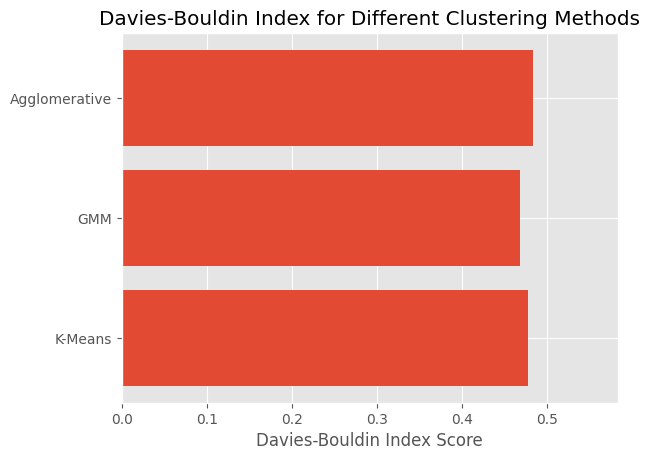

In [53]:
# Count Davies-Bouldin Index for every method of clustering
db_index_kmeans = davies_bouldin_score(var_data_standardized_kmeans, test1_clusters_kmeans)
db_index_gmm = davies_bouldin_score(var_data_standardized_gmm, test1_clusters_gmm)
db_index_aglo = davies_bouldin_score(var_data_standardized_aglo, test1_clusters_aglo)

# Display the result
print(f"Davies-Bouldin Index K-Means: {db_index_kmeans}")
print(f"Davies-Bouldin Index GMM: {db_index_gmm}")
print(f"Davies-Bouldin Index Agglomerative Clustering: {db_index_aglo}")

methods = ['K-Means', 'GMM', 'Agglomerative']
scores = [db_index_kmeans, db_index_gmm, db_index_aglo]

# Create a bar chart
plt.barh(methods, scores)
plt.xlabel('Davies-Bouldin Index Score')
plt.title('Davies-Bouldin Index for Different Clustering Methods')
plt.xlim([0, max(scores) + 0.1])  # Adjust the x-axis limits if needed

# Display the plot
plt.show()


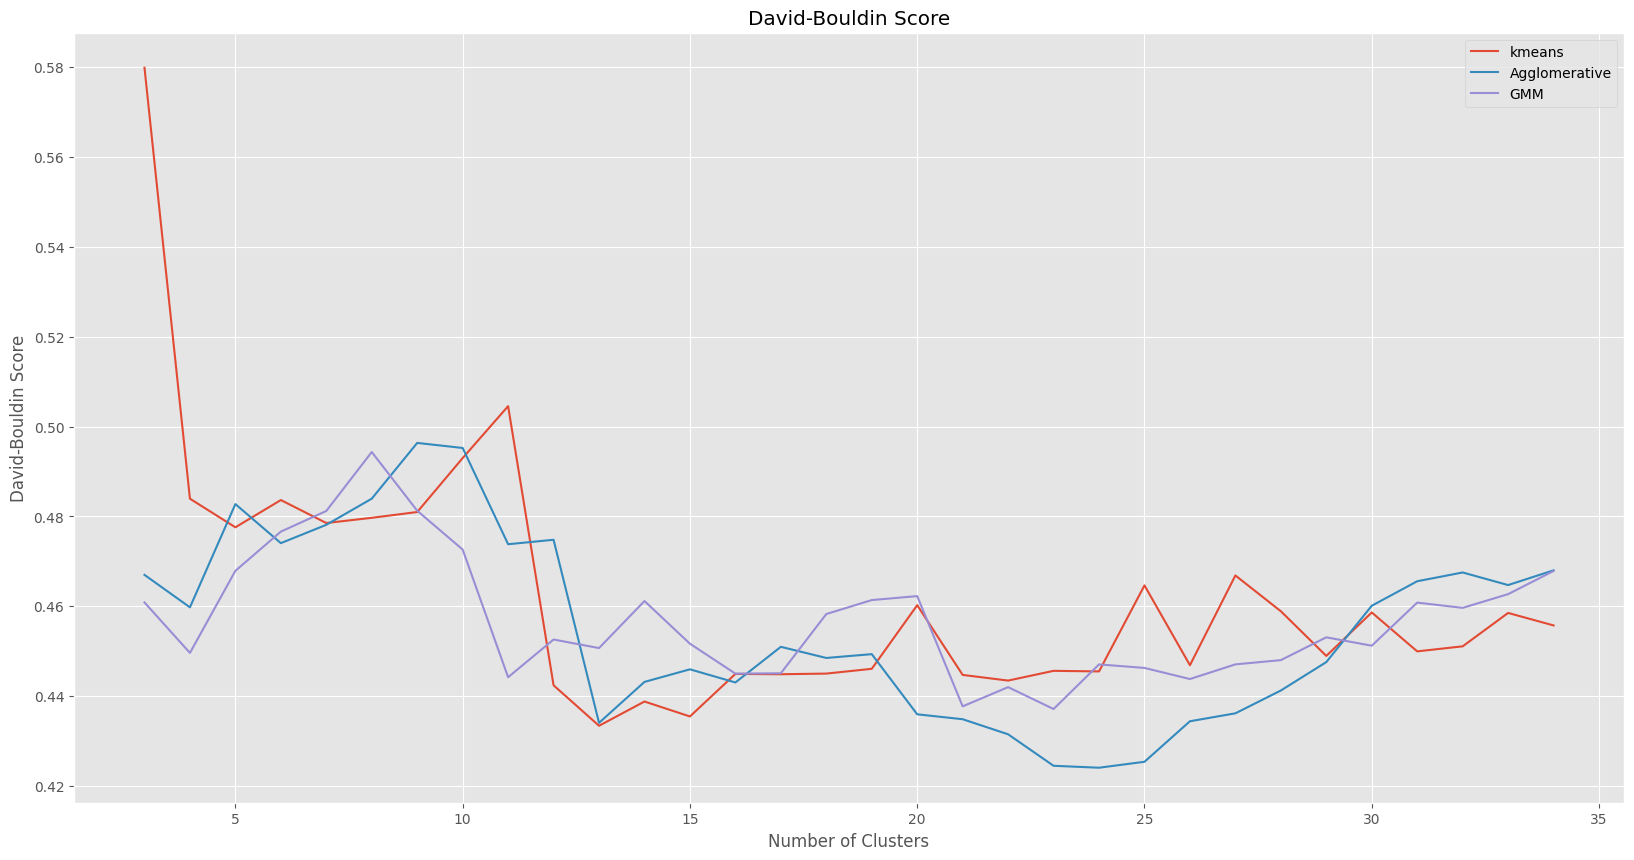

In [54]:
clusters=range(3,35,1)

# Compute the Davies Bouldin score for K means cluster within the range 
scores_dbi = []
for k in clusters:
    km = KMeans(n_clusters=k,random_state=0, n_init=10)
    labels = km.fit_predict(var_data_standardized_kmeans)
    score = davies_bouldin_score(var_data_standardized_kmeans,labels)
    scores_dbi.append(score)


plt.figure(figsize=(20,10))
plt.plot(clusters,scores_dbi)

# Compute the Davies Bouldin score for Agglomerative cluster within the range
scores_dbi = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k)
    labels = ag.fit_predict(var_data_standardized_aglo)
    score = davies_bouldin_score(var_data_standardized_aglo,labels)
    scores_dbi.append(score)

plt.plot(clusters,scores_dbi)

# Compute the Davies Bouldin score for GMM cluster within the range
scores_dbi = []
for k in clusters:
    gm =GaussianMixture(n_components=k, random_state=42)
    labels = gm.fit_predict(var_data_standardized_gmm)
    score = davies_bouldin_score(var_data_standardized_gmm,labels)
    scores_dbi.append(score)

plt.plot(clusters,scores_dbi)

plt.title('David-Bouldin Score')
plt.xlabel('Number of Clusters')
plt.ylabel('David-Bouldin Score')
plt.legend(['kmeans','Agglomerative','GMM'])

# Kesimpulan

Hasil penelitian kami menunjukkan bahwa dalam kasus kami dengan lima klaster, Kmeans menunjukkan tingkat kesamaan yang lebih baik antara data dalam setiap klaster dibandingkan dengan algoritma lainnya berdasarkan perhitungan Silhouette. Di sisi lain, ketika menilik Davies-Bouldin Index (DBI), GMM menunjukkan tingkat kepadatan anggota yang lebih baik dalam setiap klaster dibandingkan dengan kedua algoritma lainnya.

Dalam kesimpulan, dari analisis grafik yang kami lakukan, Kmeans tampaknya menjadi pilihan algoritma terbaik karena konsistensinya yang lebih baik dalam setiap klaster ketika dievaluasi dengan metrik Silhouette maupun DBI.